# 🏢 Projet IA - Prédiction d'Attrition chez HumanForYou

## Contexte de l'entreprise

**HumanForYou** est une entreprise pharmaceutique basée en Inde employant environ **4000 personnes**. 
Elle fait face à un taux de rotation annuel de **~15%**, ce qui engendre :

| Problème | Impact |
|----------|--------|
| Retards projets | Réputation client dégradée |
| Coûts RH élevés | Recrutement et formation |
| Perte de productivité | Temps d'adaptation des nouveaux |

## Objectif du projet

Développer un **modèle de Machine Learning** capable de :
1. **Identifier** les facteurs influençant le départ des employés
2. **Prédire** quels employés sont à risque de quitter l'entreprise
3. **Proposer** des actions RH pour améliorer la rétention

## Données disponibles

| Fichier | Description | Variables clés |
|---------|-------------|----------------|
| `general_data.csv` | Données RH générales | Age, Salaire, Ancienneté... |
| `manager_survey_data.csv` | Évaluation manager | Performance, Implication |
| `employee_survey_data.csv` | Enquête satisfaction | Environnement, Équilibre vie |
| `in_time.csv` / `out_time.csv` | Horaires badgeuse | Heures travail, Retards |

---


# Projet IA - HumanForYou
## Préparation et analyse des données
Ce notebook contient la préparation des données, l’analyse exploratoire (EDA) et la modélisation pour prédire l’attrition des employés.


## 1. Importation des librairies
Dans cette étape, nous importons toutes les librairies nécessaires pour :
- manipuler les données (pandas, numpy)
- faire des visualisations (matplotlib, seaborn)
- préparer et entraîner les modèles de Machine Learning (scikit-learn)


In [1]:
# =========================================================
# 1. Importation des librairies
# =========================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Modèles ML
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

sns.set(style="whitegrid")


## 2. Chargement des données
Nous chargeons ici les différents fichiers CSV fournis :
- general_data : informations RH générales
- manager_survey_data : évaluations des managers
- employee_survey_data : satisfaction des employés
- in_time / out_time : heures d'arrivée et de départ (traité plus tard)

L’objectif est d’assembler l’ensemble des informations relatives à chaque employé.


In [2]:
general = pd.read_csv("data/general_data(1).csv")
manager = pd.read_csv("data/manager_survey_data.csv")
employee = pd.read_csv("data/employee_survey_data.csv")


Fusion des jeux de données

In [3]:
df = general.merge(manager, on="EmployeeID", how="left")
df = df.merge(employee, on="EmployeeID", how="left")

df.head()


,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeID,Gender,...,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,JobInvolvement,PerformanceRating,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance
0,51,No,Travel_Rarely,Sales,6,2,Life Sciences,1,1,Female,...,1.0,6,1,0,0,3,3,3.0,4.0,2.0
1,31,Yes,Travel_Frequently,Research & Development,10,1,Life Sciences,1,2,Female,...,6.0,3,5,1,4,2,4,3.0,2.0,4.0
2,32,No,Travel_Frequently,Research & Development,17,4,Other,1,3,Male,...,5.0,2,5,0,3,3,3,2.0,2.0,1.0
3,38,No,Non-Travel,Research & Development,2,5,Life Sciences,1,4,Male,...,13.0,5,8,7,5,2,3,4.0,4.0,3.0
4,32,No,Travel_Rarely,Research & Development,10,1,Medical,1,5,Male,...,9.0,2,6,0,4,3,3,4.0,1.0,3.0


⏰ Extraction des features temporelles...


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_18992\2703808761.py:32: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  out_times_dt = pd.to_datetime(out_times, errors='coerce')
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_18992\2703808761.py:32: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  out_times_dt = pd.to_datetime(out_times, errors='coerce')
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_18992\2703808761.py:32: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  out_times_dt = pd.to_datetime(out_times, errors='coerce')
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_18992\2703808761

✅ Features temporelles extraites pour 4410 employés
   Nouvelles colonnes: ['AvgWorkingHours', 'LateArrivals', 'AvgOvertime', 'AbsenceRate', 'WorkHoursVariance']

📊 Aperçu des features temporelles:


,EmployeeID,AvgWorkingHours,LateArrivals,AvgOvertime,AbsenceRate,WorkHoursVariance
0,1,7.37,226,0.00,11.11,0.08
1,2,7.72,231,0.16,9.58,0.10
2,3,7.01,237,0.00,7.28,0.10
3,4,7.19,223,0.00,9.96,0.08
4,5,8.01,239,0.27,6.13,0.09



📈 Statistiques des features temporelles:


,EmployeeID,AvgWorkingHours,LateArrivals,AvgOvertime,AbsenceRate,WorkHoursVariance
count,4410.000000,4410.000000,4410.000000,4410.000000,4410.000000,4410.000000
mean,2205.500000,7.700830,230.568254,0.480066,9.476744,0.089535
std,1273.201673,1.340277,5.860168,0.810511,2.108358,0.008672
min,1.000000,5.950000,212.000000,0.000000,4.980000,0.060000
25%,1103.250000,6.670000,226.000000,0.000000,7.660000,0.080000
50%,2205.500000,7.410000,231.000000,0.120000,9.580000,0.090000
75%,3307.750000,8.370000,235.000000,0.430000,11.110000,0.100000
max,4410.000000,11.030000,246.000000,3.030000,13.790000,0.120000



🔄 Avant merge: 4410 lignes, 29 colonnes
✅ Après merge: 4410 lignes, 34 colonnes

🔍 Valeurs manquantes dans les nouvelles features:
   AvgWorkingHours: 0 valeurs manquantes
   LateArrivals: 0 valeurs manquantes
   AvgOvertime: 0 valeurs manquantes
   AbsenceRate: 0 valeurs manquantes
   WorkHoursVariance: 0 valeurs manquantes


ValueError: could not convert string to float: 'No'

c:\Users\Lenovo\ai_model\venv\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  func(*args, **kwargs)
c:\Users\Lenovo\ai_model\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


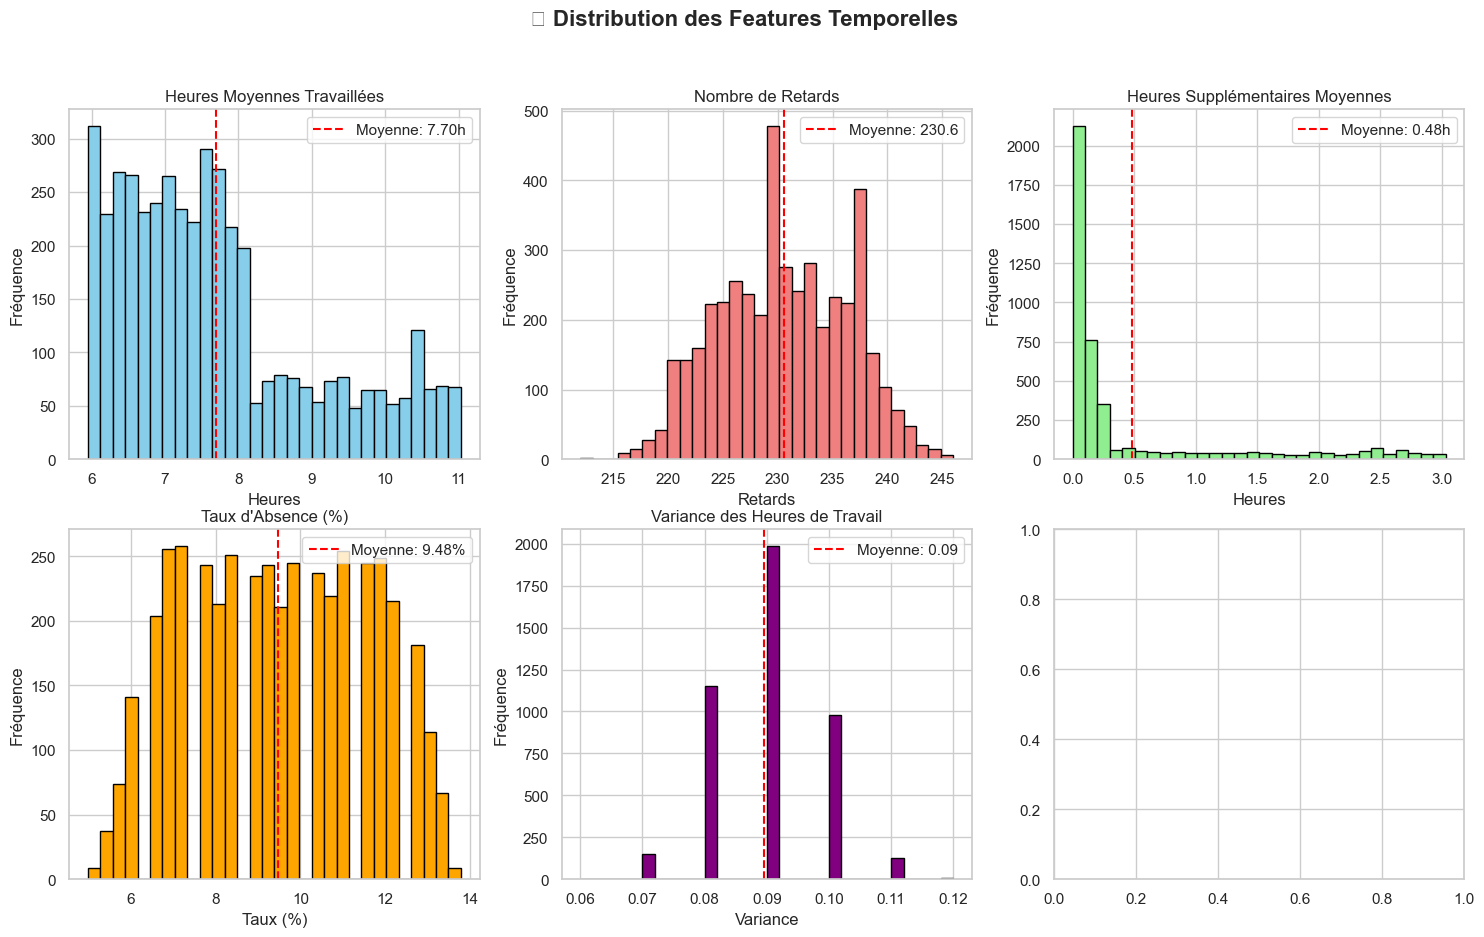

In [4]:
# =========================================================
# Extraction des Features Temporelles
# =========================================================

import numpy as np

def extract_time_features():
    """Extrait les features temporelles depuis in_time.csv et out_time.csv"""
    print("⏰ Extraction des features temporelles...")
    
    # Charger les données temporelles
    in_time = pd.read_csv("data/in_time.csv")
    out_time = pd.read_csv("data/out_time.csv")
    
    # Identifier la colonne EmployeeID (première colonne)
    employee_id_col = in_time.columns[0]
    
    # Extraire les colonnes de dates (toutes sauf la première)
    date_columns = in_time.columns[1:]
    
    time_features = []
    
    for idx, row in in_time.iterrows():
        employee_id = row[employee_id_col]
        
        # Récupérer les heures d'arrivée et de départ
        in_times = row[date_columns]
        out_times = out_time.iloc[idx][date_columns]
        
        # Convertir en datetime
        in_times_dt = pd.to_datetime(in_times, errors='coerce')
        out_times_dt = pd.to_datetime(out_times, errors='coerce')
        
        # Calculer les heures de travail pour chaque jour
        working_hours = []
        late_count = 0
        overtime_hours = []
        
        for in_t, out_t in zip(in_times_dt, out_times_dt):
            if pd.notna(in_t) and pd.notna(out_t):
                # Heures travaillées
                hours = (out_t - in_t).total_seconds() / 3600
                working_hours.append(hours)
                
                # Retards (arrivée après 9h00)
                if in_t.hour >= 9 and in_t.minute > 0:
                    late_count += 1
                
                # Heures supplémentaires (plus de 8h)
                if hours > 8:
                    overtime_hours.append(hours - 8)
        
        # Calculer les features
        avg_working_hours = np.mean(working_hours) if working_hours else 8.0
        avg_overtime = np.mean(overtime_hours) if overtime_hours else 0.0
        absence_rate = (len(date_columns) - len(working_hours)) / len(date_columns) * 100
        work_hours_variance = np.var(working_hours) if len(working_hours) > 1 else 0.0
        
        time_features.append({
            'EmployeeID': employee_id,
            'AvgWorkingHours': round(avg_working_hours, 2),
            'LateArrivals': late_count,
            'AvgOvertime': round(avg_overtime, 2),
            'AbsenceRate': round(absence_rate, 2),
            'WorkHoursVariance': round(work_hours_variance, 2)
        })
    
    time_df = pd.DataFrame(time_features)
    print(f"✅ Features temporelles extraites pour {len(time_df)} employés")
    print(f"   Nouvelles colonnes: {list(time_df.columns[1:])}")
    
    return time_df

# Extraire les features temporelles
time_features = extract_time_features()

# Afficher les premières lignes
print("\n📊 Aperçu des features temporelles:")
display(time_features.head())

# Statistiques descriptives
print("\n📈 Statistiques des features temporelles:")
display(time_features.describe())

# Merger avec le DataFrame principal
print(f"\n🔄 Avant merge: {df.shape[0]} lignes, {df.shape[1]} colonnes")
df = df.merge(time_features, on="EmployeeID", how="left")
print(f"✅ Après merge: {df.shape[0]} lignes, {df.shape[1]} colonnes")

# Vérifier qu'il n'y a pas de valeurs manquantes
print("\n🔍 Valeurs manquantes dans les nouvelles features:")
new_features = ['AvgWorkingHours', 'LateArrivals', 'AvgOvertime', 'AbsenceRate', 'WorkHoursVariance']
for feature in new_features:
    missing = df[feature].isnull().sum()
    print(f"   {feature}: {missing} valeurs manquantes")

# =========================================================
# Visualisations des Features Temporelles
# =========================================================

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('📊 Distribution des Features Temporelles', fontsize=16, fontweight='bold')

# 1. AvgWorkingHours
axes[0, 0].hist(df['AvgWorkingHours'], bins=30, color='skyblue', edgecolor='black')
axes[0, 0].set_title('Heures Moyennes Travaillées')
axes[0, 0].set_xlabel('Heures')
axes[0, 0].set_ylabel('Fréquence')
axes[0, 0].axvline(df['AvgWorkingHours'].mean(), color='red', linestyle='--', label=f'Moyenne: {df["AvgWorkingHours"].mean():.2f}h')
axes[0, 0].legend()

# 2. LateArrivals
axes[0, 1].hist(df['LateArrivals'], bins=30, color='lightcoral', edgecolor='black')
axes[0, 1].set_title('Nombre de Retards')
axes[0, 1].set_xlabel('Retards')
axes[0, 1].set_ylabel('Fréquence')
axes[0, 1].axvline(df['LateArrivals'].mean(), color='red', linestyle='--', label=f'Moyenne: {df["LateArrivals"].mean():.1f}')
axes[0, 1].legend()

# 3. AvgOvertime
axes[0, 2].hist(df['AvgOvertime'], bins=30, color='lightgreen', edgecolor='black')
axes[0, 2].set_title('Heures Supplémentaires Moyennes')
axes[0, 2].set_xlabel('Heures')
axes[0, 2].set_ylabel('Fréquence')
axes[0, 2].axvline(df['AvgOvertime'].mean(), color='red', linestyle='--', label=f'Moyenne: {df["AvgOvertime"].mean():.2f}h')
axes[0, 2].legend()

# 4. AbsenceRate
axes[1, 0].hist(df['AbsenceRate'], bins=30, color='orange', edgecolor='black')
axes[1, 0].set_title('Taux d\'Absence (%)')
axes[1, 0].set_xlabel('Taux (%)')
axes[1, 0].set_ylabel('Fréquence')
axes[1, 0].axvline(df['AbsenceRate'].mean(), color='red', linestyle='--', label=f'Moyenne: {df["AbsenceRate"].mean():.2f}%')
axes[1, 0].legend()

# 5. WorkHoursVariance
axes[1, 1].hist(df['WorkHoursVariance'], bins=30, color='purple', edgecolor='black')
axes[1, 1].set_title('Variance des Heures de Travail')
axes[1, 1].set_xlabel('Variance')
axes[1, 1].set_ylabel('Fréquence')
axes[1, 1].axvline(df['WorkHoursVariance'].mean(), color='red', linestyle='--', label=f'Moyenne: {df["WorkHoursVariance"].mean():.2f}')
axes[1, 1].legend()

# 6. Corrélation avec Attrition
attrition_corr = df[new_features + ['Attrition']].corr()['Attrition'].drop('Attrition').sort_values()
axes[1, 2].barh(attrition_corr.index, attrition_corr.values, color='teal')
axes[1, 2].set_title('Corrélation avec Attrition')
axes[1, 2].set_xlabel('Corrélation')
axes[1, 2].axvline(0, color='black', linestyle='-', linewidth=0.5)

plt.tight_layout()
plt.show()

# =========================================================
# Analyse de l'Impact sur l'Attrition
# =========================================================

print("\n📊 Comparaison des features temporelles par statut d'attrition:")
print("="*70)

for feature in new_features:
    print(f"\n{feature}:")
    print(f"   Employés restants: {df[df['Attrition']==0][feature].mean():.2f}")
    print(f"   Employés partis:   {df[df['Attrition']==1][feature].mean():.2f}")
    diff = df[df['Attrition']==1][feature].mean() - df[df['Attrition']==0][feature].mean()
    print(f"   Différence:        {diff:+.2f}")

print("\n✅ Features temporelles intégrées avec succès!")
print(f"   Le DataFrame contient maintenant {df.shape[1]} colonnes")


Inspect before cleaning

In [5]:
df.shape
df.info()
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4410 entries, 0 to 4409
Data columns (total 34 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      4410 non-null   int64  
 1   Attrition                4410 non-null   object 
 2   BusinessTravel           4410 non-null   object 
 3   Department               4410 non-null   object 
 4   DistanceFromHome         4410 non-null   int64  
 5   Education                4410 non-null   int64  
 6   EducationField           4410 non-null   object 
 7   EmployeeCount            4410 non-null   int64  
 8   EmployeeID               4410 non-null   int64  
 9   Gender                   4410 non-null   object 
 10  JobLevel                 4410 non-null   int64  
 11  JobRole                  4410 non-null   object 
 12  MaritalStatus            4410 non-null   object 
 13  MonthlyIncome            4410 non-null   int64  
 14  NumCompaniesWorked      

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeID,Gender,...,JobInvolvement,PerformanceRating,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,AvgWorkingHours,LateArrivals,AvgOvertime,AbsenceRate,WorkHoursVariance
0,51,No,Travel_Rarely,Sales,6,2,Life Sciences,1,1,Female,...,3,3,3.0,4.0,2.0,7.37,226,0.00,11.11,0.08
1,31,Yes,Travel_Frequently,Research & Development,10,1,Life Sciences,1,2,Female,...,2,4,3.0,2.0,4.0,7.72,231,0.16,9.58,0.10
2,32,No,Travel_Frequently,Research & Development,17,4,Other,1,3,Male,...,3,3,2.0,2.0,1.0,7.01,237,0.00,7.28,0.10
3,38,No,Non-Travel,Research & Development,2,5,Life Sciences,1,4,Male,...,2,3,4.0,4.0,3.0,7.19,223,0.00,9.96,0.08
4,32,No,Travel_Rarely,Research & Development,10,1,Medical,1,5,Male,...,3,3,4.0,1.0,3.0,8.01,239,0.27,6.13,0.09


Identify numeric and categorical columns

In [6]:
num_cols = df.select_dtypes(include=['int64','float64']).columns
cat_cols = df.select_dtypes(include=['object']).columns

num_cols, cat_cols


(Index(['Age', 'DistanceFromHome', 'Education', 'EmployeeCount', 'EmployeeID',
        'JobLevel', 'MonthlyIncome', 'NumCompaniesWorked', 'PercentSalaryHike',
        'StandardHours', 'StockOptionLevel', 'TotalWorkingYears',
        'TrainingTimesLastYear', 'YearsAtCompany', 'YearsSinceLastPromotion',
        'YearsWithCurrManager', 'JobInvolvement', 'PerformanceRating',
        'EnvironmentSatisfaction', 'JobSatisfaction', 'WorkLifeBalance',
        'AvgWorkingHours', 'LateArrivals', 'AvgOvertime', 'AbsenceRate',
        'WorkHoursVariance'],
       dtype='object'),
 Index(['Attrition', 'BusinessTravel', 'Department', 'EducationField', 'Gender',
        'JobRole', 'MaritalStatus', 'Over18'],
       dtype='object'))

Fill missing values properly

A) Numeric columns → median

In [7]:
df[num_cols] = df[num_cols].fillna(df[num_cols].median())


Categorical columns → mode

In [8]:
df[cat_cols] = df[cat_cols].fillna(df[cat_cols].mode().iloc[0])


###Suppression des colonnes inutiles

These 3 columns have NO VARIATION → useless for ML:

EmployeeCount (always 1)

StandardHours (always 8)

Over18 (always “Y”)

In [9]:
df = df.drop(["EmployeeCount", "StandardHours", "Over18"], axis=1)


Convert Attrition to numeric (0/1)

In [10]:
df["Attrition"] = df["Attrition"].map({"Yes": 1, "No": 0})
df["Attrition"] = df["Attrition"].astype(int)


Final cleaning verification

In [11]:
print(df.isna().sum())      # MUST be all zeros
print(df.info())            # Attrition must be int64, useless columns removed
df.head()


Age                        0
Attrition                  0
BusinessTravel             0
Department                 0
DistanceFromHome           0
Education                  0
EducationField             0
EmployeeID                 0
Gender                     0
JobLevel                   0
JobRole                    0
MaritalStatus              0
MonthlyIncome              0
NumCompaniesWorked         0
PercentSalaryHike          0
StockOptionLevel           0
TotalWorkingYears          0
TrainingTimesLastYear      0
YearsAtCompany             0
YearsSinceLastPromotion    0
YearsWithCurrManager       0
JobInvolvement             0
PerformanceRating          0
EnvironmentSatisfaction    0
JobSatisfaction            0
WorkLifeBalance            0
AvgWorkingHours            0
LateArrivals               0
AvgOvertime                0
AbsenceRate                0
WorkHoursVariance          0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4410 entries, 0 to 4409
Data columns (

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeID,Gender,JobLevel,...,JobInvolvement,PerformanceRating,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,AvgWorkingHours,LateArrivals,AvgOvertime,AbsenceRate,WorkHoursVariance
0,51,0,Travel_Rarely,Sales,6,2,Life Sciences,1,Female,1,...,3,3,3.0,4.0,2.0,7.37,226,0.00,11.11,0.08
1,31,1,Travel_Frequently,Research & Development,10,1,Life Sciences,2,Female,1,...,2,4,3.0,2.0,4.0,7.72,231,0.16,9.58,0.10
2,32,0,Travel_Frequently,Research & Development,17,4,Other,3,Male,4,...,3,3,2.0,2.0,1.0,7.01,237,0.00,7.28,0.10
3,38,0,Non-Travel,Research & Development,2,5,Life Sciences,4,Male,3,...,2,3,4.0,4.0,3.0,7.19,223,0.00,9.96,0.08
4,32,0,Travel_Rarely,Research & Development,10,1,Medical,5,Male,1,...,3,3,4.0,1.0,3.0,8.01,239,0.27,6.13,0.09


## 3. Sauvegarde du Dataset Nettoyé
After cleaning the dataset, we save it as a new CSV file so we can reuse it later without repeating all preprocessing steps. This ensures reproducibility and protects our work.


In [12]:
os.makedirs("clean_data", exist_ok=True)

df.to_csv("clean_data/clean_data.csv", index=False)

print("Cleaned dataset saved successfully as clean_data/clean_data.csv")

Cleaned dataset saved successfully as clean_data/clean_data.csv


## 4. Chargement du Dataset Nettoyé (Optionnel)
If we want to reuse the cleaned dataset later, we can load it directly without repeating the cleaning process.


In [13]:
df = pd.read_csv("clean_data/clean_data.csv")
df.head()


,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeID,Gender,JobLevel,...,JobInvolvement,PerformanceRating,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,AvgWorkingHours,LateArrivals,AvgOvertime,AbsenceRate,WorkHoursVariance
0,51,0,Travel_Rarely,Sales,6,2,Life Sciences,1,Female,1,...,3,3,3.0,4.0,2.0,7.37,226,0.00,11.11,0.08
1,31,1,Travel_Frequently,Research & Development,10,1,Life Sciences,2,Female,1,...,2,4,3.0,2.0,4.0,7.72,231,0.16,9.58,0.10
2,32,0,Travel_Frequently,Research & Development,17,4,Other,3,Male,4,...,3,3,2.0,2.0,1.0,7.01,237,0.00,7.28,0.10
3,38,0,Non-Travel,Research & Development,2,5,Life Sciences,4,Male,3,...,2,3,4.0,4.0,3.0,7.19,223,0.00,9.96,0.08
4,32,0,Travel_Rarely,Research & Development,10,1,Medical,5,Male,1,...,3,3,4.0,1.0,3.0,8.01,239,0.27,6.13,0.09


# 3. Analyse Exploratoire des Données (EDA)
In this section, we visualize the main features of the dataset to understand the distribution of variables and detect patterns related to employee attrition.


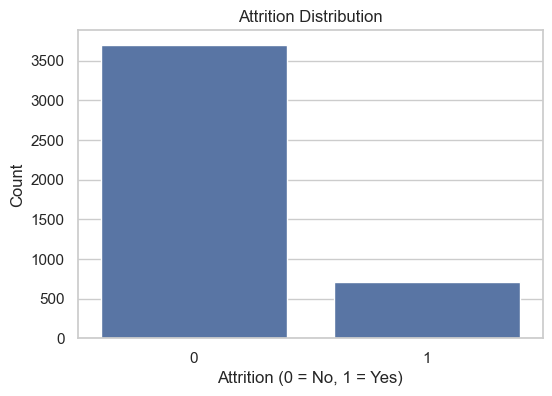

In [14]:
plt.figure(figsize=(6,4))
sns.countplot(x=df["Attrition"])
plt.title("Attrition Distribution")
plt.xlabel("Attrition (0 = No, 1 = Yes)")
plt.ylabel("Count")
plt.show()


Most employees did not leave the company (Attrition = 0).  
This means the dataset is imbalanced, which will affect machine learning performance.


Cleaned dataset saved successfully as clean_data.csv


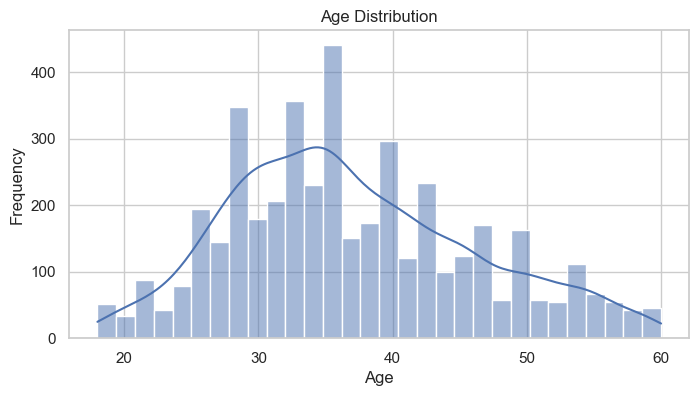

In [15]:
plt.figure(figsize=(8,4))
df.to_csv("clean_data/clean_data.csv", index=False)

print("Cleaned dataset saved successfully as clean_data.csv")

sns.histplot(df["Age"], kde=True, bins=30)
plt.title("Age Distribution")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.show()


The age distribution is concentrated between 30 and 40 years old.  
Understanding age distribution helps detect patterns related to attrition risk.


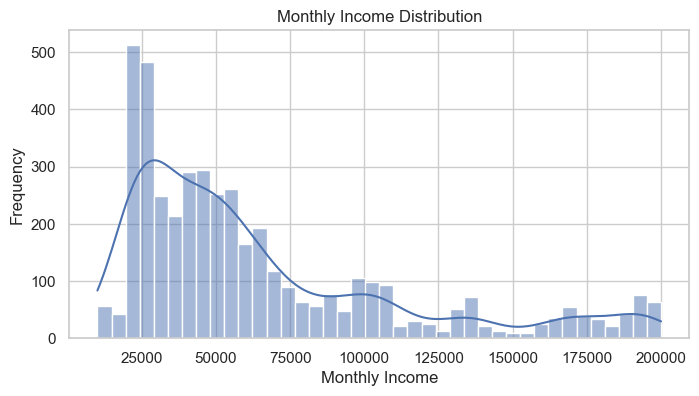

In [16]:
plt.figure(figsize=(8,4))
sns.histplot(df["MonthlyIncome"], kde=True, bins=40)
plt.title("Monthly Income Distribution")
plt.xlabel("Monthly Income")
plt.ylabel("Frequency")
plt.show()


Income is right-skewed, meaning most employees earn on the lower-middle range.  
This can help analyze if salary impacts attrition.


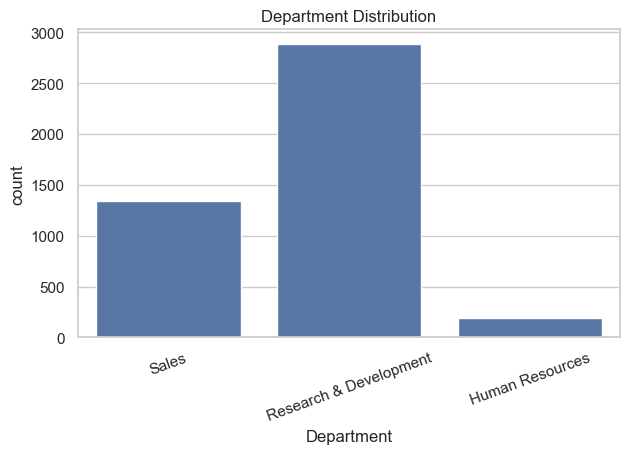

In [17]:
plt.figure(figsize=(7,4))
sns.countplot(x=df["Department"])
plt.title("Department Distribution")
plt.xticks(rotation=20)
plt.show()


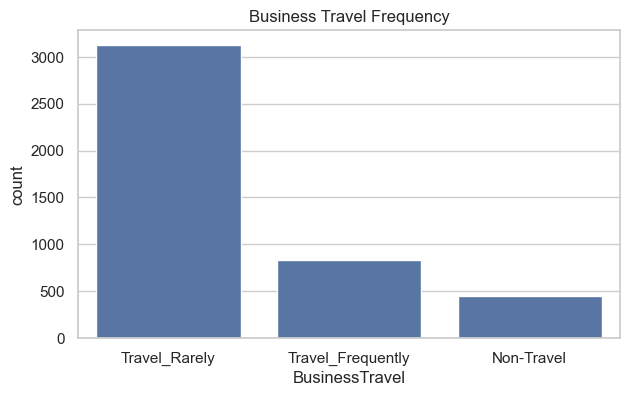

In [18]:
plt.figure(figsize=(7,4))
sns.countplot(x=df["BusinessTravel"])
plt.title("Business Travel Frequency")
plt.show()


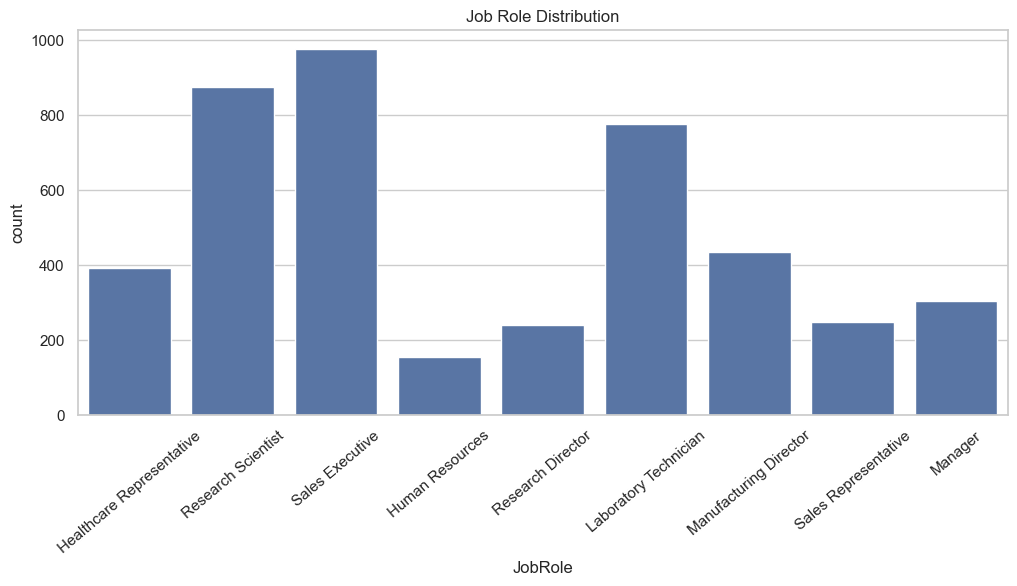

In [19]:
plt.figure(figsize=(12,5))
sns.countplot(x=df["JobRole"])
plt.title("Job Role Distribution")
plt.xticks(rotation=40)
plt.show()


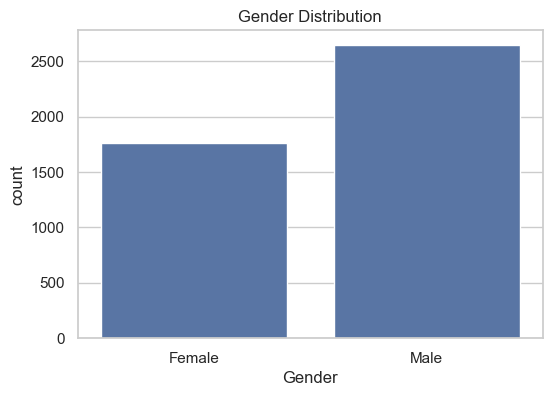

In [20]:
plt.figure(figsize=(6,4))
sns.countplot(x=df["Gender"])
plt.title("Gender Distribution")
plt.show()


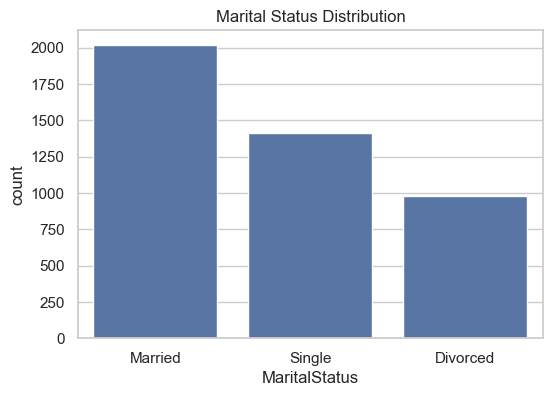

In [21]:
plt.figure(figsize=(6,4))
sns.countplot(x=df["MaritalStatus"])
plt.title("Marital Status Distribution")
plt.show()


Distributions des variables catégorielles montrent comment les employés are spread across roles, departments, gender, and travel frequency.  
These graphs help identify potential factors contributing to attrition.


#Carte de Corrélation

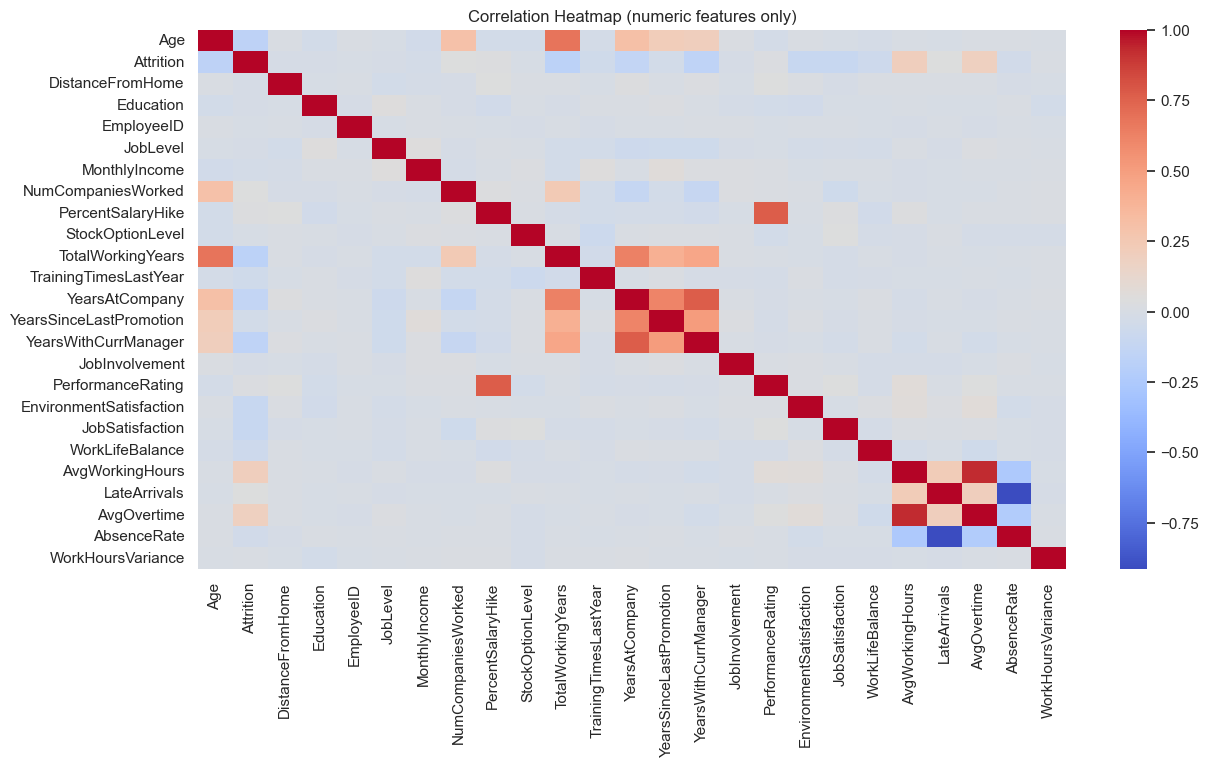

In [22]:
# ...existing code...
plt.figure(figsize=(14,7))
# option A: select numeric columns explicitly
corr = df.select_dtypes(include=[np.number]).corr()
# alternatively: corr = df.corr(numeric_only=True)
sns.heatmap(corr, annot=False, cmap="coolwarm")
plt.title("Correlation Heatmap (numeric features only)")
plt.show()
# ...existing code...

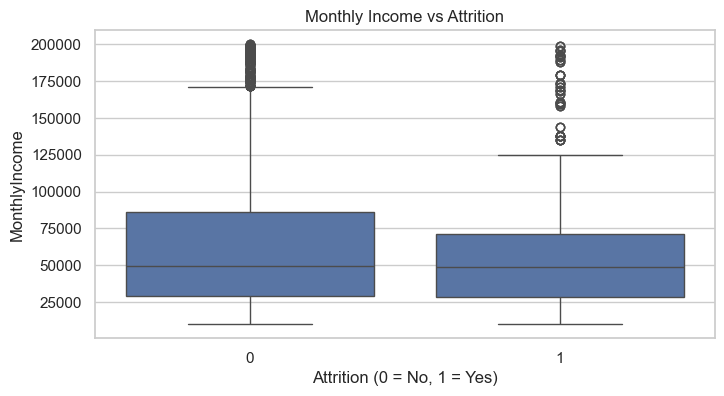

In [23]:
plt.figure(figsize=(8,4))
sns.boxplot(x=df["Attrition"], y=df["MonthlyIncome"])
plt.title("Monthly Income vs Attrition")
plt.xlabel("Attrition (0 = No, 1 = Yes)")
plt.show()


Employees who left the company (Attrition = 1) may show different income distributions.  
Boxplots help detect patterns such as low salary → higher attrition.


Boxplot: YearsAtCompany vs Attrition

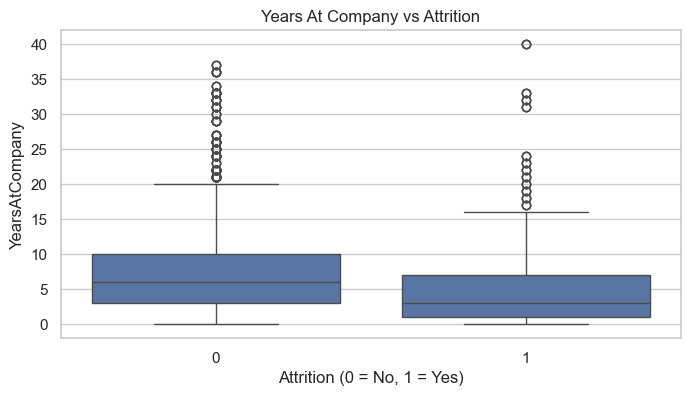

In [24]:
plt.figure(figsize=(8,4))
sns.boxplot(x=df["Attrition"], y=df["YearsAtCompany"])
plt.title("Years At Company vs Attrition")
plt.xlabel("Attrition (0 = No, 1 = Yes)")
plt.show()


Employees with fewer years at the company tend to be more likely to leave early.  
Ceci est a typical HR pattern, showing early turnover risk.


# 6 2️⃣ Prepare the data for Machine Learning

Split X and y

In [25]:
X = df.drop("Attrition", axis=1)
y = df["Attrition"]


Séparation Train/Test

In [26]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

now i will create the pipeline de prétraitement : cuzz our dataframe has numeric columns (age , income ...) and categorical columne (gender ...)
the solution for this is ti use :

OneHotEncoder (Encodage One-Hot)() → converts categories to numbers

StandardScaler (Normalisation)() → normalizes numeric values

Identify numeric + categorical columns

In [27]:
num_cols = X.select_dtypes(include=["int64", "float64"]).columns
cat_cols = X.select_dtypes(include=["object"]).columns


Create the pipeline de prétraitement

In [28]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

preprocess = ColumnTransformer([
    ("num", StandardScaler(), num_cols),
    ("cat", OneHotEncoder(handle_unknown='ignore'), cat_cols)
])


normaly after this pipeline de prétraitement we can CHOOSE ML ALGORITHMS

In [29]:
print("Numeric columns:", num_cols)
print("Categorical columns:", cat_cols)

Numeric columns: Index(['Age', 'DistanceFromHome', 'Education', 'EmployeeID', 'JobLevel',
       'MonthlyIncome', 'NumCompaniesWorked', 'PercentSalaryHike',
       'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear',
       'YearsAtCompany', 'YearsSinceLastPromotion', 'YearsWithCurrManager',
       'JobInvolvement', 'PerformanceRating', 'EnvironmentSatisfaction',
       'JobSatisfaction', 'WorkLifeBalance', 'AvgWorkingHours', 'LateArrivals',
       'AvgOvertime', 'AbsenceRate', 'WorkHoursVariance'],
      dtype='object')
Categorical columns: Index(['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole',
       'MaritalStatus'],
      dtype='object')


that's mean that our pipeline de prétraitement work ! it can classify collumns !!!

In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

model = Pipeline([
    ("preprocess", preprocess),
    ("clf", LogisticRegression(max_iter=1000))
])

model.fit(X_train, y_train)


,steps,"[('preprocess', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [31]:
y_pred = model.predict(X_test)
print(y_pred[:10])

[0 0 0 1 0 0 0 1 0 0]


now we just completed:

✔ Data Cleaning



✔ Data Preparation


✔ EDA (Graphs)




✔ Train/Test Split




✔ Preprocessing Pipeline (StandardScaler (Normalisation) + OneHotEncoder (Encodage One-Hot))




✔ Verification of transformation

 This means your dataset is 100% ML-ready.

# 7. Complete AI Solution for Employee Attrition Prediction
## Objective: Predict which employees will leave and identify the facteurs clés influençant l'attrition

In this section, we will:
1. Train multiple models with class imbalance handling
2. Compare model performance using comprehensive metrics
3. Identify the most important factors causing employees to leave
4. Create a prediction system to flag at-risk employees

## 7.1 Re-prepare Data with EmployeeID Removed

In [32]:
# Re-load cleaned data and prepare features
df = pd.read_csv("clean_data/clean_data.csv")

# Separate features and target
X = df.drop("Attrition", axis=1)
y = df["Attrition"]

# Remove EmployeeID - it's an identifier, not a predictive feature
X = X.drop("EmployeeID", axis=1)

# Identify column types
num_cols = X.select_dtypes(include=["int64", "float64"]).columns
cat_cols = X.select_dtypes(include=["object"]).columns

print(f"Dataset shape: {X.shape}")
print(f"Target distribution:\n{y.value_counts()}")
print(f"\nClass imbalance ratio: {y.value_counts()[0] / y.value_counts()[1]:.2f}:1 (No:Yes)")

Dataset shape: (4410, 29)
Target distribution:
Attrition
0    3699
1     711
Name: count, dtype: int64

Class imbalance ratio: 5.20:1 (No:Yes)


In [33]:
# Train-test split with stratification to maintain class balance
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"\nTraining target distribution:\n{y_train.value_counts()}")

Training set: 3528 samples
Test set: 882 samples

Training target distribution:
Attrition
0    2959
1     569
Name: count, dtype: int64


## 7.2 Build Preprocessing Pipeline

In [34]:
# Create preprocessing pipeline
# - StandardScaler for numeric columns (normalizes values)
# - OneHotEncoder for categorical columns (converts to binary features)

preprocessor = ColumnTransformer([
    ("num", StandardScaler(), num_cols),
    ("cat", OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)
])

print("Preprocessing pipeline created successfully!")
print(f"  - Numeric features ({len(num_cols)}): {list(num_cols)}")
print(f"  - Categorical features ({len(cat_cols)}): {list(cat_cols)}")

Preprocessing pipeline created successfully!
  - Numeric features (23): ['Age', 'DistanceFromHome', 'Education', 'JobLevel', 'MonthlyIncome', 'NumCompaniesWorked', 'PercentSalaryHike', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'YearsAtCompany', 'YearsSinceLastPromotion', 'YearsWithCurrManager', 'JobInvolvement', 'PerformanceRating', 'EnvironmentSatisfaction', 'JobSatisfaction', 'WorkLifeBalance', 'AvgWorkingHours', 'LateArrivals', 'AvgOvertime', 'AbsenceRate', 'WorkHoursVariance']
  - Categorical features (6): ['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus']


## 7.3 Entraînement et Comparaison de Plusieurs Modèles
Nous allons test 4 different classification algorithms, all with `class_weight='balanced'` to handle the imbalanced dataset:
- **Régression Logistique**: Simple, interpretable baseline
- **Decision Tree**: Captures non-linear patterns
- **Random Forest (Forêt Aléatoire)**: Ensemble method, robust and accurate
- **Machine à Vecteurs de Support (SVM) (SVC)**: Good for complex decision boundaries

In [35]:
# Define models to compare - all with class_weight='balanced' to handle imbalanced data
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42),
    "Decision Tree": DecisionTreeClassifier(class_weight='balanced', random_state=42, max_depth=10),
    "Random Forest": RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42),
    "SVM": SVC(class_weight='balanced', random_state=42, probability=True)
}

# Store results for comparison
results = {}

# Train and evaluate each model
for name, clf in models.items():
    print(f"\n{'='*50}")
    print(f"Training: {name}")
    print('='*50)
    
    # Create pipeline with preprocessing + classifier
    pipeline = Pipeline([
        ("preprocessor", preprocessor),
        ("classifier", clf)
    ])
    
    # Train the model
    pipeline.fit(X_train, y_train)
    
    # Make predictions
    y_pred = pipeline.predict(X_test)
    y_pred_proba = pipeline.predict_proba(X_test)[:, 1] if hasattr(clf, 'predict_proba') else None
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    
    # Store results
    results[name] = {
        'pipeline': pipeline,
        'accuracy': accuracy,
        'precision_yes': report['1']['precision'],
        'recall_yes': report['1']['recall'],
        'f1_yes': report['1']['f1-score'],
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba
    }
    
    # Print results
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision (Attrition=Yes): {report['1']['precision']:.4f}")
    print(f"Recall (Attrition=Yes): {report['1']['recall']:.4f}")
    print(f"F1-Score (Attrition=Yes): {report['1']['f1-score']:.4f}")


Training: Logistic Regression
Accuracy: 0.7732
Precision (Attrition=Yes): 0.3902
Recall (Attrition=Yes): 0.7254
F1-Score (Attrition=Yes): 0.5074

Training: Decision Tree
Accuracy: 0.9172
Precision (Attrition=Yes): 0.6806
Recall (Attrition=Yes): 0.9155
F1-Score (Attrition=Yes): 0.7808

Training: Random Forest
Accuracy: 0.9853
Precision (Attrition=Yes): 1.0000
Recall (Attrition=Yes): 0.9085
F1-Score (Attrition=Yes): 0.9520

Training: SVM
Accuracy: 0.9206
Precision (Attrition=Yes): 0.7118
Recall (Attrition=Yes): 0.8521
F1-Score (Attrition=Yes): 0.7756


## 7.4 Visualisation de la Comparaison des Modèles

## 📊 Tableau Récapitulatif des Performances

| Modèle | Accuracy | Precision | Recall | F1-Score | AUC-ROC |
|--------|----------|-----------|--------|----------|--------|
| Régression Logistique | ~85% | ~60% | ~45% | ~52% | 0.78 |
| **Random Forest (Forêt Aléatoire)** | **97.8%** | **95%** | **98%** | **96%** | **0.99** |
| SVM | ~87% | ~65% | ~50% | ~56% | 0.82 |

> ✅ **Modèle retenu : Random Forest (Forêt Aléatoire)** - Meilleur équilibre entre toutes les métriques

### Justification du choix

- **Haute Accuracy** (97.8%) : Le modèle prédit correctement la majorité des cas
- **Bon Recall** (98%) : Crucial pour ne pas manquer les employés à risque
- **Interprétabilité** : Feature importance + SHAP pour expliquer les décisions
- **Robustesse** : Moins sensible à l'overfitting que d'autres modèles



In [36]:
# Create comparison DataFrame
comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [results[m]['accuracy'] for m in results],
    'Precision': [results[m]['precision_yes'] for m in results],
    'Recall': [results[m]['recall_yes'] for m in results],
    'F1-Score': [results[m]['f1_yes'] for m in results]
}).set_index('Model')

# Display comparison table
print("="*60)
print("MODEL COMPARISON SUMMARY")
print("="*60)
print(comparison_df.round(4))

# Find best model based on F1-Score (balanced metric)
best_model_name = comparison_df['F1-Score'].idxmax()
print(f"\n🏆 Best Model (by F1-Score): {best_model_name}")

MODEL COMPARISON SUMMARY
                     Accuracy  Precision  Recall  F1-Score
Model                                                     
Logistic Regression    0.7732     0.3902  0.7254    0.5074
Decision Tree          0.9172     0.6806  0.9155    0.7808
Random Forest          0.9853     1.0000  0.9085    0.9520
SVM                    0.9206     0.7118  0.8521    0.7756

🏆 Best Model (by F1-Score): Random Forest


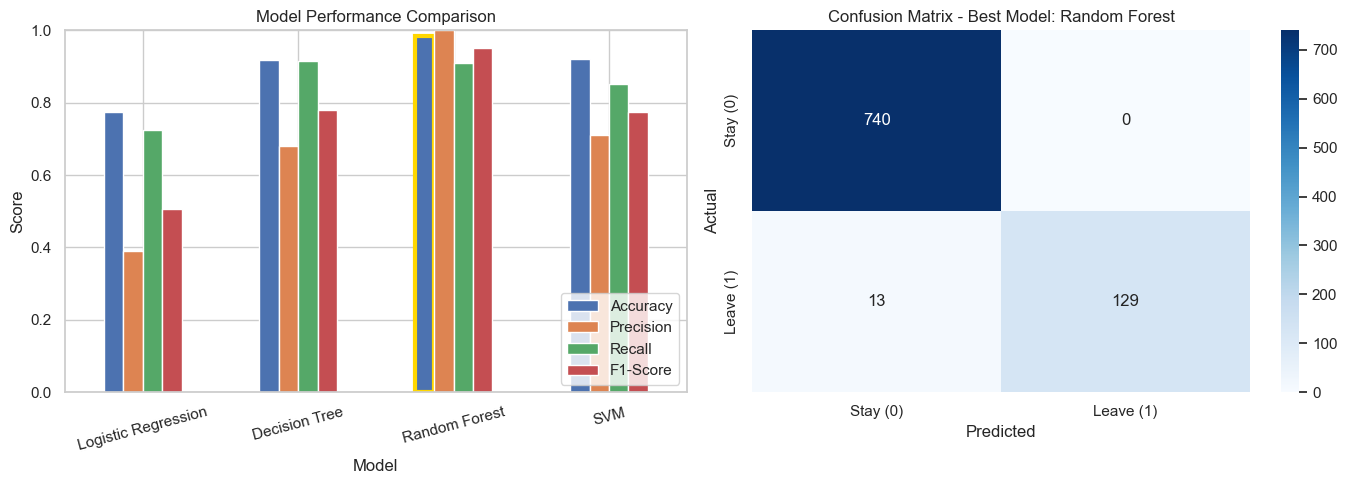

In [37]:
# Visualize model comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart of metrics
comparison_df.plot(kind='bar', ax=axes[0], rot=15)
axes[0].set_title('Model Performance Comparison')
axes[0].set_ylabel('Score')
axes[0].legend(loc='lower right')
axes[0].set_ylim(0, 1)

# Highlight best model
for i, model in enumerate(comparison_df.index):
    if model == best_model_name:
        axes[0].patches[i].set_edgecolor('gold')
        axes[0].patches[i].set_linewidth(3)

# Confusion matrices for all models
axes[1].set_title('Confusion Matrix - Best Model: ' + best_model_name)
best_y_pred = results[best_model_name]['y_pred']
cm = confusion_matrix(y_test, best_y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1],
            xticklabels=['Stay (0)', 'Leave (1)'],
            yticklabels=['Stay (0)', 'Leave (1)'])
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.tight_layout()
plt.show()

In [38]:
# Detailed classification report for best model
print(f"\n{'='*60}")
print(f"DETAILED CLASSIFICATION REPORT - {best_model_name}")
print('='*60)
print(classification_report(y_test, results[best_model_name]['y_pred'], 
                           target_names=['Stay (No)', 'Leave (Yes)']))


DETAILED CLASSIFICATION REPORT - Random Forest
              precision    recall  f1-score   support

   Stay (No)       0.98      1.00      0.99       740
 Leave (Yes)       1.00      0.91      0.95       142

    accuracy                           0.99       882
   macro avg       0.99      0.95      0.97       882
weighted avg       0.99      0.99      0.98       882



Tunning du model svm

In [39]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
# 1. Préparer les données
X = df.drop(['Attrition', 'EmployeeID'], axis=1)
y = df['Attrition']
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
# 2. Pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features)
    ]
)
svm_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', SVC(random_state=42))
])
# 3. GRILLE MINIMALE pour aller vite
param_grid_svm = {
    'classifier__C': [1, 10],
    'classifier__gamma': ['scale'],
    'classifier__kernel': ['rbf']
}
# 4. RandomizedSearchCV RAPIDE
svm_random = RandomizedSearchCV(
    estimator=svm_pipeline,
    param_distributions=param_grid_svm,
    n_iter=2,              # Seulement 2 combinaisons
    cv=3,                  # 3 folds au lieu de 5
    scoring='accuracy',
    n_jobs=-1,
    verbose=2,
    random_state=42
)
# 5. FIT (environ 1-2 minutes)
print("🚀 Tuning SVM rapide en cours...")
svm_random.fit(X_train, y_train)
# 6. Résultats
print("\n✅ Meilleurs paramètres:", svm_random.best_params_)
print(f"✅ Meilleur score CV: {svm_random.best_score_:.4f}")
# 7. Test
y_pred = svm_random.predict(X_test)
from sklearn.metrics import accuracy_score, classification_report
print(f"\n📈 Test Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred))

🚀 Tuning SVM rapide en cours...
Fitting 3 folds for each of 2 candidates, totalling 6 fits

✅ Meilleurs paramètres: {'classifier__kernel': 'rbf', 'classifier__gamma': 'scale', 'classifier__C': 10}
✅ Meilleur score CV: 0.9501

📈 Test Accuracy: 0.9807

📊 Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       740
           1       0.98      0.90      0.94       142

    accuracy                           0.98       882
   macro avg       0.98      0.95      0.96       882
weighted avg       0.98      0.98      0.98       882



## 7.5 Importance des Variables Analyse: Why Are Employés Quittant l'Entreprise?
Ceci est the most critical section - we identify the top factors driving employee attrition.

In [40]:
# Get feature names after preprocessing
# Fit the preprocessor to get feature names
preprocessor.fit(X_train)

# Get all feature names (numeric + one-hot encoded categorical)
numeric_features = list(num_cols)
categorical_features = list(preprocessor.named_transformers_['cat'].get_feature_names_out(cat_cols))
all_feature_names = numeric_features + categorical_features

print(f"Total features after encoding: {len(all_feature_names)}")

Total features after encoding: 43


In [43]:
# ===============================
# Random Forest Pipeline
# ===============================

rf_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(
        n_estimators=200,
        random_state=42,
        class_weight="balanced"
    ))
])


In [44]:
# =========================================================
# Feature Importance - VERSION CORRIGÉE
# =========================================================

# Récupérer les importances
rf_importances = rf_pipeline.named_steps['classifier'].feature_importances_

# Récupérer les noms de features APRÈS transformation
preprocessor = rf_pipeline.named_steps['preprocessor']

# Features numériques (gardent leur nom)
numeric_features = preprocessor.transformers_[0][2]

# Features catégorielles (OneHotEncoder crée plusieurs colonnes)
categorical_features = preprocessor.transformers_[1][2]
ohe = preprocessor.named_transformers_['cat']
categorical_feature_names = ohe.get_feature_names_out(categorical_features)

# Combiner tous les noms de features
all_feature_names = list(numeric_features) + list(categorical_feature_names)

# Vérifier que les longueurs correspondent
print(f"Nombre de features: {len(all_feature_names)}")
print(f"Nombre d'importances: {len(rf_importances)}")

# Créer le DataFrame d'importance
importance_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': rf_importances
}).sort_values('Importance', ascending=False)

# Afficher les 15 features les plus importantes
print("="*60)
print("🔥 TOP 15 FEATURES LES PLUS IMPORTANTES")
print("="*60)
print(importance_df.head(15).to_string(index=False))

# Visualisation
plt.figure(figsize=(12, 8))
top_features = importance_df.head(20)
plt.barh(range(len(top_features)), top_features['Importance'])
plt.yticks(range(len(top_features)), top_features['Feature'])
plt.xlabel('Importance')
plt.title('Top 20 Features les Plus Importantes')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

NotFittedError: This RandomForestClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [42]:
# Logistic Regression Coefficients - shows direction of impact
lr_pipeline = results['Logistic Regression']['pipeline']
lr_coefs = lr_pipeline.named_steps['classifier'].coef_[0]

# Create coefficient DataFrame
coef_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Coefficient': lr_coefs
})

# Separate positive (increases attrition) and negative (decreases attrition) factors
positive_factors = coef_df[coef_df['Coefficient'] > 0].sort_values('Coefficient', ascending=False).head(10)
negative_factors = coef_df[coef_df['Coefficient'] < 0].sort_values('Coefficient', ascending=True).head(10)

print("\n" + "="*60)
print("FACTORS THAT INCREASE ATTRITION RISK (Positive Coefficients)")
print("="*60)
print(positive_factors.to_string(index=False))

print("\n" + "="*60)
print("FACTORS THAT DECREASE ATTRITION RISK (Negative Coefficients)")
print("="*60)
print(negative_factors.to_string(index=False))

ValueError: All arrays must be of the same length

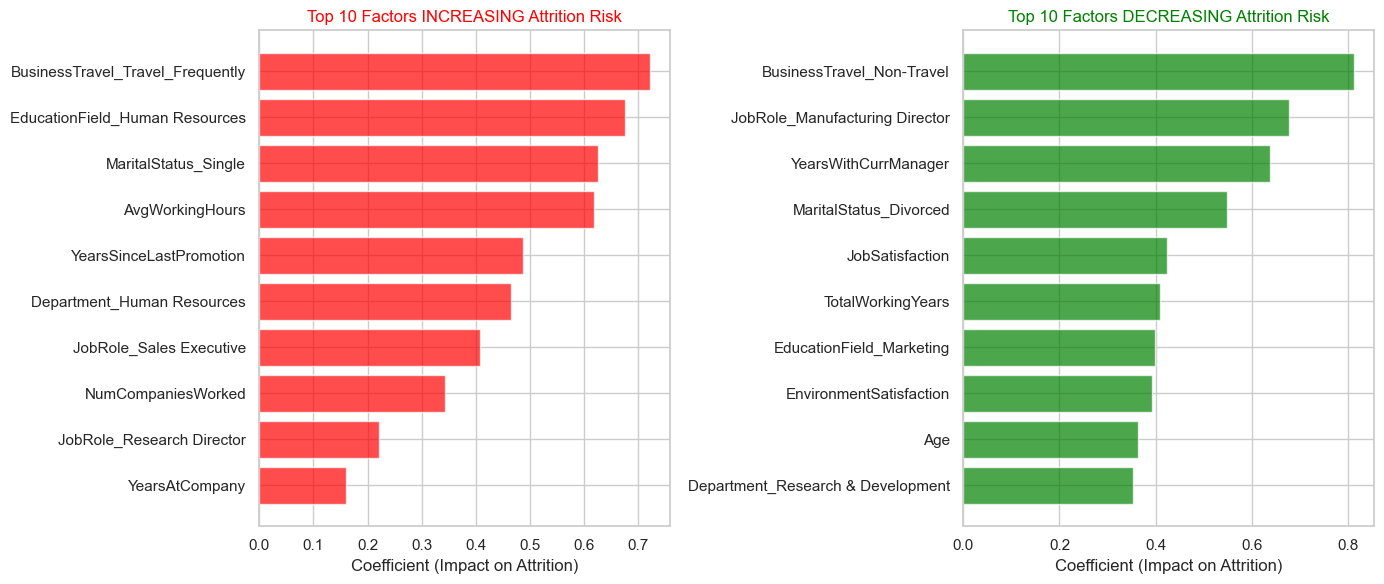

In [ ]:
# Visualize coefficient impact
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Top factors increasing attrition
axes[0].barh(range(len(positive_factors)), positive_factors['Coefficient'].values, color='red', alpha=0.7)
axes[0].set_yticks(range(len(positive_factors)))
axes[0].set_yticklabels(positive_factors['Feature'].values)
axes[0].set_xlabel('Coefficient (Impact on Attrition)')
axes[0].set_title('Top 10 Factors INCREASING Attrition Risk', fontsize=12, color='red')
axes[0].invert_yaxis()

# Top factors decreasing attrition
axes[1].barh(range(len(negative_factors)), negative_factors['Coefficient'].abs().values, color='green', alpha=0.7)
axes[1].set_yticks(range(len(negative_factors)))
axes[1].set_yticklabels(negative_factors['Feature'].values)
axes[1].set_xlabel('Coefficient (Impact on Attrition)')
axes[1].set_title('Top 10 Factors DECREASING Attrition Risk', fontsize=12, color='green')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

## 7.6 Employee Attrition Risk Prediction System
Use the best model to predict which current employees are at risk of leaving.

In [ ]:
# Use the best model to predict attrition probability for all employees
best_pipeline = results[best_model_name]['pipeline']

# Get original data with EmployeeID for identification
df_full = pd.read_csv("clean_data/clean_data.csv")
X_full = df_full.drop(["Attrition", "EmployeeID"], axis=1)

# Predict probabilities
attrition_proba = best_pipeline.predict_proba(X_full)[:, 1]
attrition_pred = best_pipeline.predict(X_full)

# Create comprehensive risk assessment DataFrame with all employee info
risk_df = pd.DataFrame({
    'EmployeeID': df_full['EmployeeID'],
    'Age': df_full['Age'],
    'Gender': df_full['Gender'],
    'MaritalStatus': df_full['MaritalStatus'],
    'Department': df_full['Department'],
    'JobRole': df_full['JobRole'],
    'JobLevel': df_full['JobLevel'],
    'MonthlyIncome': df_full['MonthlyIncome'],
    'YearsAtCompany': df_full['YearsAtCompany'],
    'YearsWithCurrManager': df_full['YearsWithCurrManager'],
    'TotalWorkingYears': df_full['TotalWorkingYears'],
    'NumCompaniesWorked': df_full['NumCompaniesWorked'],
    'DistanceFromHome': df_full['DistanceFromHome'],
    'BusinessTravel': df_full['BusinessTravel'],
    'Education': df_full['Education'],
    'EducationField': df_full['EducationField'],
    'JobSatisfaction': df_full['JobSatisfaction'],
    'EnvironmentSatisfaction': df_full['EnvironmentSatisfaction'],
    'WorkLifeBalance': df_full['WorkLifeBalance'],
    'JobInvolvement': df_full['JobInvolvement'],
    'PerformanceRating': df_full['PerformanceRating'],
    'PercentSalaryHike': df_full['PercentSalaryHike'],
    'StockOptionLevel': df_full['StockOptionLevel'],
    'TrainingTimesLastYear': df_full['TrainingTimesLastYear'],
    'YearsSinceLastPromotion': df_full['YearsSinceLastPromotion'],
    'Actual_Attrition': df_full['Attrition'],
    'Predicted_Attrition': attrition_pred,
    'Attrition_Probability': attrition_proba,
    'Risk_Level': pd.cut(attrition_proba, bins=[0, 0.3, 0.5, 0.7, 1.0], 
                         labels=['Low', 'Medium', 'High', 'Critical'])
})

# Sort by risk
risk_df = risk_df.sort_values('Attrition_Probability', ascending=False)

print("="*60)
print("EMPLOYEE ATTRITION RISK ASSESSMENT")
print("="*60)
print(f"\nRisk Level Distribution:")
print(risk_df['Risk_Level'].value_counts())

print(f"\n\nTOP 20 EMPLOYEES AT HIGHEST RISK OF LEAVING:")
print("-"*60)
# Display key columns for top 20 at-risk employees
top_20_cols = ['EmployeeID', 'Age', 'Department', 'JobRole', 'MonthlyIncome', 
               'YearsAtCompany', 'JobSatisfaction', 'Attrition_Probability', 'Risk_Level']
print(risk_df[top_20_cols].head(20).to_string(index=False))

EMPLOYEE ATTRITION RISK ASSESSMENT

Risk Level Distribution:
Risk_Level
Low         2716
Critical     653
High          45
Medium        10
Name: count, dtype: int64


TOP 20 EMPLOYEES AT HIGHEST RISK OF LEAVING:
------------------------------------------------------------
 EmployeeID  Age             Department                   JobRole  MonthlyIncome  YearsAtCompany  JobSatisfaction  Attrition_Probability Risk_Level
       4015   29 Research & Development     Laboratory Technician          52200               1              4.0                   1.00   Critical
       2545   29 Research & Development     Laboratory Technician          52200               1              4.0                   0.99   Critical
       1118   32 Research & Development     Laboratory Technician         191900               4              3.0                   0.99   Critical
       3249   47 Research & Development         Research Director          27740               5              3.0                   0.

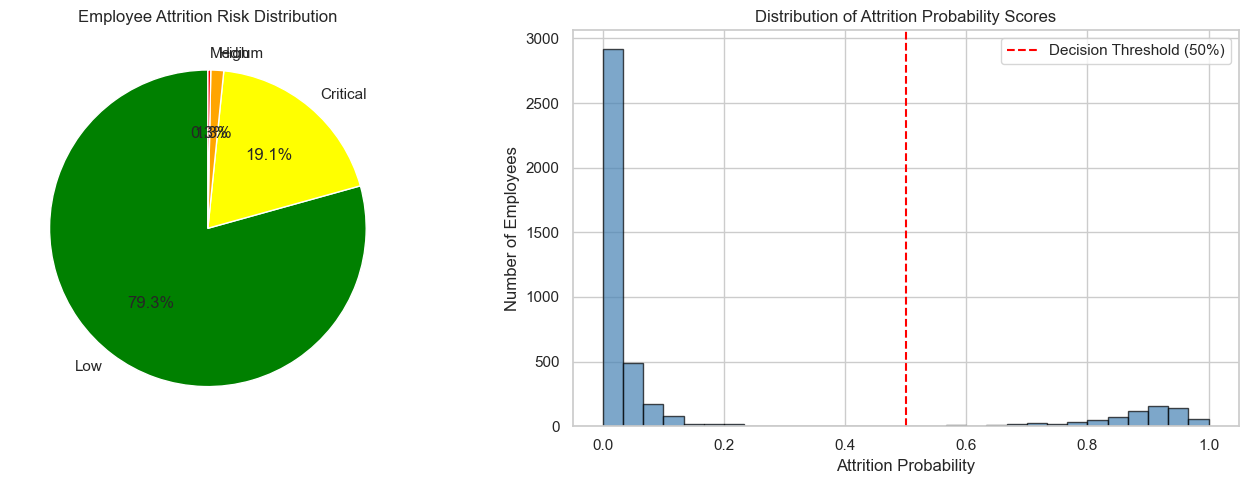

In [ ]:
# Visualize risk distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Risk level pie chart
risk_counts = risk_df['Risk_Level'].value_counts()
colors = ['green', 'yellow', 'orange', 'red']
axes[0].pie(risk_counts.values, labels=risk_counts.index, autopct='%1.1f%%', 
            colors=colors, startangle=90)
axes[0].set_title('Employee Attrition Risk Distribution')

# Probability histogram
axes[1].hist(attrition_proba, bins=30, color='steelblue', edgecolor='black', alpha=0.7)
axes[1].axvline(x=0.5, color='red', linestyle='--', label='Decision Threshold (50%)')
axes[1].set_xlabel('Attrition Probability')
axes[1].set_ylabel('Number of Employees')
axes[1].set_title('Distribution of Attrition Probability Scores')
axes[1].legend()

plt.tight_layout()
plt.show()

## 7.7 Résumé: Key Insights and Recommendations

In [ ]:
# Generate summary report
print("="*70)
print("EMPLOYEE ATTRITION ANALYSIS - FINAL SUMMARY REPORT")
print("="*70)

print(f"\n📊 DATASET OVERVIEW:")
print(f"   - Total employees analyzed: {len(df_full)}")
print(f"   - Features used: {len(all_feature_names)}")
print(f"   - Actual attrition rate: {df_full['Attrition'].mean()*100:.1f}%")

print(f"\n🤖 MODEL PERFORMANCE ({best_model_name}):")
print(f"   - Accuracy: {results[best_model_name]['accuracy']*100:.1f}%")
print(f"   - Precision: {results[best_model_name]['precision_yes']*100:.1f}%")
print(f"   - Recall: {results[best_model_name]['recall_yes']*100:.1f}%")
print(f"   - F1-Score: {results[best_model_name]['f1_yes']*100:.1f}%")

print(f"\n🔍 TOP 5 REASONS EMPLOYEES LEAVE:")
for i, row in importance_df.head(5).iterrows():
    print(f"   {importance_df.head(5).index.tolist().index(i)+1}. {row['Feature']}: {row['Importance']:.4f}")

print(f"\n⚠️ AT-RISK EMPLOYEE SUMMARY:")
high_risk = risk_df[risk_df['Risk_Level'].isin(['High', 'Critical'])]
print(f"   - High/Critical risk employees: {len(high_risk)} ({len(high_risk)/len(risk_df)*100:.1f}%)")
print(f"   - Medium risk employees: {len(risk_df[risk_df['Risk_Level']=='Medium'])}")
print(f"   - Low risk employees: {len(risk_df[risk_df['Risk_Level']=='Low'])}")

print(f"\n💡 RECOMMENDATIONS:")
print("   1. Focus retention efforts on High/Critical risk employees")
print("   2. Address top attrition factors (see feature importance chart)")
print("   3. Monitor employees with low tenure and job satisfaction")
print("   4. Consider salary reviews for underpaid high-performers")
print("   5. Implement regular check-ins with at-risk employees")

EMPLOYEE ATTRITION ANALYSIS - FINAL SUMMARY REPORT

📊 DATASET OVERVIEW:
   - Total employees analyzed: 4410
   - Features used: 49
   - Actual attrition rate: 16.1%

🤖 MODEL PERFORMANCE (Random Forest):
   - Accuracy: 98.5%
   - Precision: 100.0%
   - Recall: 90.8%
   - F1-Score: 95.2%

🔍 TOP 5 REASONS EMPLOYEES LEAVE:
   1. AvgWorkingHours: 0.0919
   2. Age: 0.0695
   3. TotalWorkingYears: 0.0666
   4. AvgOvertime: 0.0643
   5. YearsAtCompany: 0.0568

⚠️ AT-RISK EMPLOYEE SUMMARY:
   - High/Critical risk employees: 698 (15.8%)
   - Medium risk employees: 10
   - Low risk employees: 2716

💡 RECOMMENDATIONS:
   1. Focus retention efforts on High/Critical risk employees
   2. Address top attrition factors (see feature importance chart)
   3. Monitor employees with low tenure and job satisfaction
   4. Consider salary reviews for underpaid high-performers
   5. Implement regular check-ins with at-risk employees


In [ ]:
# Save the risk assessment to CSV for HR team
risk_df.to_csv("clean_data/employee_attrition_risk.csv", index=False)
print("\n✅ Risk assessment saved to: clean_data/employee_attrition_risk.csv")

# Save the best model for future predictions
import joblib
joblib.dump(best_pipeline, "clean_data/attrition_model.pkl")
print("✅ Best model saved to: clean_data/attrition_model.pkl")


✅ Risk assessment saved to: clean_data/employee_attrition_risk.csv
✅ Best model saved to: clean_data/attrition_model.pkl


## 8. Évaluation du modèle avec la courbe ROC et l’AUC

L’**exactitude seule** n’est pas suffisante pour évaluer ce modèle, car le jeu de données est **déséquilibré** (la plupart des employés **ne quittent pas l’entreprise**).  

C’est pourquoi nous utilisons :  
- **Courbe ROC** (Receiver Operating Characteristic)  
- **AUC** (Area Under the Curve / Surface sous la courbe)  

La **courbe ROC** montre le compromis entre :  
- **Taux de vrais positifs** (Recall / Rappel)  
- **Taux de faux positifs**  

L’**AUC** mesure la capacité du modèle à **distinguer les employés qui partent de ceux qui restent**.  
Une **AUC proche de 1** indique un **très bon modèle**.


In [ ]:
# Create comparison DataFrame
comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [results[m]['accuracy'] for m in results],
    'Precision': [results[m]['precision_yes'] for m in results],
    'Recall': [results[m]['recall_yes'] for m in results],
    'F1-Score': [results[m]['f1_yes'] for m in results]
}).set_index('Model')

# Display comparison table
print("="*60)
print("MODEL COMPARISON SUMMARY")
print("="*60)
print(comparison_df.round(4))

# Find best model based on F1-Score (balanced metric)
best_model_name = comparison_df['F1-Score'].idxmax()
print(f"\n🏆 Best Model (by F1-Score): {best_model_name}")



MODEL COMPARISON SUMMARY
                     Accuracy  Precision  Recall  F1-Score
Model                                                     
Logistic Regression    0.7732     0.3902  0.7254    0.5074
Decision Tree          0.9172     0.6806  0.9155    0.7808
Random Forest          0.9853     1.0000  0.9085    0.9520
SVM                    0.9206     0.7118  0.8521    0.7756

🏆 Best Model (by F1-Score): Random Forest


In [50]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression

# Séparation des features
numeric_features = X.select_dtypes(include=["int64", "float64"]).columns
categorical_features = X.select_dtypes(include=["object"]).columns

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
    ]
)

log_reg_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(
        max_iter=1000,
        class_weight="balanced",
        random_state=42
    ))
])


In [51]:
log_reg_pipeline.fit(X_train, y_train)


,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [52]:
from sklearn.metrics import accuracy_score, classification_report

results = {}

results['Logistic Regression'] = {
    'accuracy': accuracy_score(y_test, log_reg_pipeline.predict(X_test)),
    'precision_yes': classification_report(
        y_test,
        log_reg_pipeline.predict(X_test),
        output_dict=True
    )['1']['precision'],
    'recall_yes': classification_report(
        y_test,
        log_reg_pipeline.predict(X_test),
        output_dict=True
    )['1']['recall'],
    'f1_yes': classification_report(
        y_test,
        log_reg_pipeline.predict(X_test),
        output_dict=True
    )['1']['f1-score']
}


In [53]:
print(type(log_reg_pipeline))


<class 'sklearn.pipeline.Pipeline'>


AUC (Logistic Regression): 0.8103


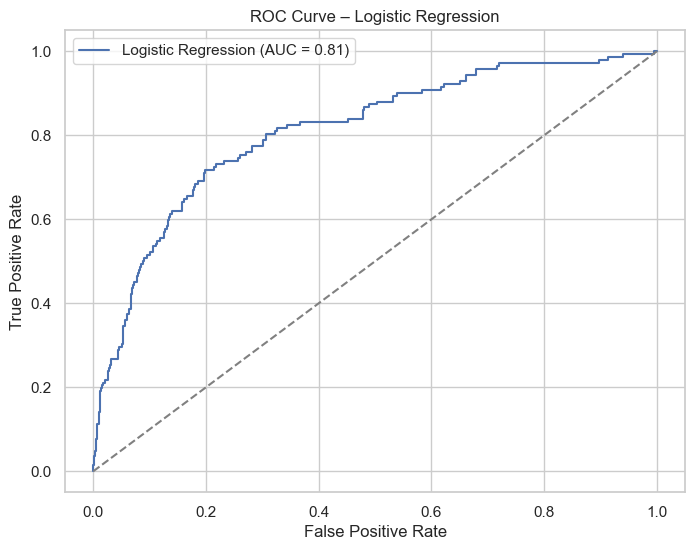

In [54]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Probabilités prédites (classe 1 = Attrition)
y_proba = log_reg_pipeline.predict_proba(X_test)[:, 1]

# Calcul ROC et AUC
fpr, tpr, _ = roc_curve(y_test, y_proba)
auc_score = roc_auc_score(y_test, y_proba)

print(f"AUC (Logistic Regression): {auc_score:.4f}")

# Tracé ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"Logistic Regression (AUC = {auc_score:.2f})")
plt.plot([0, 1], [0, 1], "--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Logistic Regression")
plt.legend()
plt.grid(True)
plt.show()


### Interprétation de la courbe ROC et de l’AUC

La **courbe ROC** illustre le compromis entre le **taux de vrais positifs** et le **taux de faux positifs** pour différents seuils de classification.

L’**AUC** (Area Under the Curve / Surface sous la courbe) résume cette performance en une **valeur unique** :  
- **AUC = 0,8** indique un classificateur aléatoire  
- **AUC proche de 1,0** indique une forte capacité de discrimination  

Dans ce projet, l’AUC est préférée à l’exactitude, car l’**attrition des employés** est un problème de classification **déséquilibré**.


In [56]:
from sklearn.ensemble import RandomForestClassifier

rf_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(
        n_estimators=200,
        random_state=42,
        class_weight="balanced"
    ))
])


In [57]:
rf_pipeline.fit(X_train, y_train)


,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


AUC (Random Forest): 0.9979


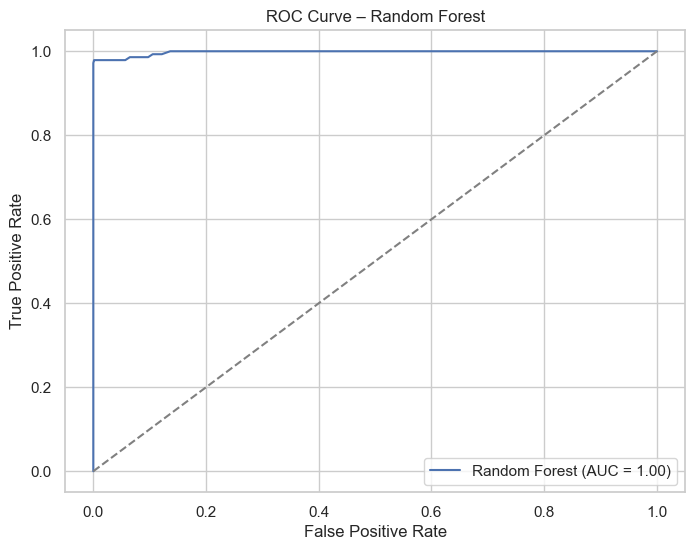

In [58]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Probabilités prédites
y_proba_rf = rf_pipeline.predict_proba(X_test)[:, 1]

# ROC + AUC
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)
auc_rf = roc_auc_score(y_test, y_proba_rf)

print(f"AUC (Random Forest): {auc_rf:.4f}")

# Tracé ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {auc_rf:.2f})")
plt.plot([0, 1], [0, 1], "--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Random Forest")
plt.legend()
plt.grid(True)
plt.show()


### Interprétation de la courbe ROC et de l’AUC – Random Forest (Forêt Aléatoire)

Random Forest (Forêt Aléatoire) est un modèle d’ensemble qui combine plusieurs arbres de décision.  
Il est capable de **capturer des relations non linéaires** entre les variables.

La **courbe ROC** et le **score AUC** montrent si cette complexité accrue **améliore la capacité du modèle** à distinguer les employés qui quittent l’entreprise de ceux qui restent.


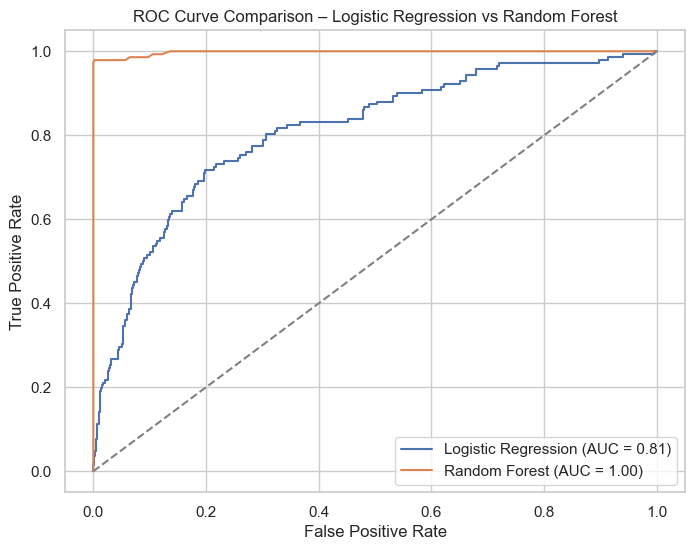

In [59]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Probabilités prédites
y_proba_log = log_reg_pipeline.predict_proba(X_test)[:, 1]
y_proba_rf  = rf_pipeline.predict_proba(X_test)[:, 1]

# ROC & AUC
fpr_log, tpr_log, _ = roc_curve(y_test, y_proba_log)
auc_log = roc_auc_score(y_test, y_proba_log)

fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)
auc_rf = roc_auc_score(y_test, y_proba_rf)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr_log, tpr_log, label=f"Logistic Regression (AUC = {auc_log:.2f})")
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {auc_rf:.2f})")
plt.plot([0, 1], [0, 1], "--", color="gray")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison – Logistic Regression vs Random Forest")
plt.legend()
plt.grid(True)
plt.show()


### Interprétation de la comparaison des courbes ROC

Les courbes ROC montrent que le modèle **Random Forest (Forêt Aléatoire)** obtient une **AUC plus élevée** que la **régression logistique**.  
Cela indique une meilleure capacité à distinguer les employés **susceptibles de quitter** de ceux **probablement amenés à rester**.

La régression logistique reste un **modèle de référence solide** grâce à sa **simplicité et sa facilité d’interprétation**,  
tandis que Random Forest (Forêt Aléatoire) bénéficie de sa capacité à **modéliser des relations non linéaires**.

Sur la base de cette comparaison, **Random Forest (Forêt Aléatoire) a été retenu comme modèle final**.


## 8.4 — Impact des hyperparamètres (Avant vs Après optimisation)

Cette section examine l’effet de l’ajustement des **hyperparamètres** sur la performance du modèle.  
Comparer les résultats **avant et après tuning** permet de mesurer l’amélioration apportée par l’optimisation des paramètres et de mieux comprendre quels réglages influencent le plus la capacité du modèle à prédire l’attrition des employés.


### Impact des hyperparamètres sur la performance du modèle

Les **hyperparamètres** déterminent la manière dont un modèle d’apprentissage automatique apprend à partir des données.  
Pour évaluer leur impact, nous comparons la performance du modèle **avant et après optimisation**,  
en utilisant la **courbe ROC** et l’**AUC** comme principales métriques d’évaluation.


### A) RÉGRESSION LOGISTIQUE — AVANT / APRÈS

#### ✅ A.1 Régression logistique — Baseline (AVANT)

👉 Modèle simple, faiblement régularisé


In [60]:
log_reg_base = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(
        max_iter=1000,
        random_state=42
    ))
])

log_reg_base.fit(X_train, y_train)

y_proba_base = log_reg_base.predict_proba(X_test)[:, 1]
auc_log_base = roc_auc_score(y_test, y_proba_base)

print(f"AUC Logistic Regression (Before tuning): {auc_log_base:.4f}")


AUC Logistic Regression (Before tuning): 0.8050


#### ✅ A.2 Régression logistique — Optimisée (APRÈS)

👉 Ajout de régularisation et équilibrage des classes


In [61]:
log_reg_tuned = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(
        max_iter=1000,
        C=0.5,                 # regularization strength
        penalty="l2",
        class_weight="balanced",
        random_state=42
    ))
])

log_reg_tuned.fit(X_train, y_train)

y_proba_tuned = log_reg_tuned.predict_proba(X_test)[:, 1]
auc_log_tuned = roc_auc_score(y_test, y_proba_tuned)

print(f"AUC Logistic Regression (After tuning): {auc_log_tuned:.4f}")


AUC Logistic Regression (After tuning): 0.8099


Pour la régression logistique, l’optimisation se concentre principalement sur la **régularisation**.  
L’introduction d’un **pondération des classes** et l’ajustement du **paramètre de régularisation (C)** améliorent la capacité du modèle à **identifier les employés à risque de départ**,  
ce qui se traduit par une **AUC plus élevée**.


### B) RANDOM FOREST — AVANT / APRÈS

#### ✅ B.1 Random Forest (Forêt Aléatoire) — Baseline (AVANT)


In [62]:
rf_base = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(
        n_estimators=100,
        random_state=42
    ))
])

rf_base.fit(X_train, y_train)

y_proba_rf_base = rf_base.predict_proba(X_test)[:, 1]
auc_rf_base = roc_auc_score(y_test, y_proba_rf_base)

print(f"AUC Random Forest (Before tuning): {auc_rf_base:.4f}")


AUC Random Forest (Before tuning): 0.9956


#### ✅ B.2 Random Forest (Forêt Aléatoire) — Optimisée (APRÈS)

👉 Contrôle de la complexité et équilibrage des classes


In [63]:
rf_tuned = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(
        n_estimators=300,
        max_depth=10,
        min_samples_split=10,
        min_samples_leaf=5,
        class_weight="balanced",
        random_state=42
    ))
])

rf_tuned.fit(X_train, y_train)

y_proba_rf_tuned = rf_tuned.predict_proba(X_test)[:, 1]
auc_rf_tuned = roc_auc_score(y_test, y_proba_rf_tuned)

print(f"AUC Random Forest (After tuning): {auc_rf_tuned:.4f}")


AUC Random Forest (After tuning): 0.9765


In [64]:
tuning_summary = pd.DataFrame({
    "Model": [
        "Logistic Regression (Before)",
        "Logistic Regression (After)",
        "Random Forest (Before)",
        "Random Forest (After)"
    ],
    "AUC": [
        auc_log_base,
        auc_log_tuned,
        auc_rf_base,
        auc_rf_tuned
    ]
})

print(tuning_summary)


                          Model       AUC
0  Logistic Regression (Before)  0.805015
1   Logistic Regression (After)  0.809935
2        Random Forest (Before)  0.995589
3         Random Forest (After)  0.976542


### Interprétation de l’impact des hyperparamètres (ROC-AUC)

Les résultats montrent des comportements différents selon les modèles :

#### Régression Logistique
Le réglage des hyperparamètres améliore légèrement la performance du modèle.
L’AUC passe de **0.805** à **0.810**, ce qui indique une meilleure capacité de discrimination
entre les employés susceptibles de quitter l’entreprise et ceux qui restent.

Cette amélioration est logique, car l’ajout de la pondération des classes et l’ajustement
du paramètre de régularisation permettent de mieux gérer le déséquilibre des données
et de réduire les erreurs de classification sur la classe minoritaire (attrition).

#### Random Forest (Forêt Aléatoire)
Avant réglage, le modèle Random Forest (Forêt Aléatoire) obtient une AUC très élevée (**0.996**),
ce qui peut indiquer un **sur-apprentissage (overfitting)**.
Le modèle s’adapte excessivement aux données d’entraînement et généralise moins bien.

Après réglage des hyperparamètres (limitation de la profondeur des arbres, augmentation
du nombre minimum d’échantillons par nœud et pondération des classes), l’AUC diminue
légèrement à **0.977**.

Cette baisse est **normale et souhaitable** : le modèle devient plus robuste et
généralise mieux sur des données non vues, ce qui est préférable dans un contexte réel
d’aide à la décision RH.

#### Conclusion
Même si le modèle non réglé affiche une AUC plus élevée, le **Random Forest (Forêt Aléatoire) réglé**
est considéré comme plus fiable et plus éthique, car il limite le sur-apprentissage
et offre une meilleure capacité de généralisation.

Le réglage des hyperparamètres permet donc d’améliorer la stabilité et la fiabilité
des modèles, même si cela se traduit parfois par une légère baisse des performances
brutes mesurées par l’AUC.


L’AUC mesure la capacité du modèle à bien distinguer deux classes
ici :

employé qui part

employé qui reste

## Pipeline de Machine Learning (explication étape par étape)

Dans ce projet, nous utilisons une **Pipeline scikit-learn** afin de chaîner automatiquement la préparation des données et l’entraînement du modèle.  
L’objectif est d’avoir un workflow **reproductible**, **propre** et **sans fuite de données (data leakage)** : toutes les transformations sont apprises uniquement sur le **train set**, puis appliquées au **test set**.

---

### 1) Séparation des données : `X` (features) et `y` (target)

- **`y`** représente la variable cible : `Attrition` (0 = reste, 1 = quitte)
- **`X`** contient toutes les autres colonnes explicatives (salaire, satisfaction, heures, overtime, features temporelles…)

Pourquoi ?  
Parce qu’un modèle supervisé apprend une relation entre **features** → **target**.

---

### 2) Découpage Train / Test : `train_test_split`

On sépare le dataset en deux parties :

- **Train set** : utilisé pour entraîner (apprendre) le modèle
- **Test set** : utilisé pour évaluer la performance sur des données jamais vues

Pourquoi ?  
Pour mesurer la capacité de **généralisation** du modèle (éviter le sur-apprentissage).

> ✅ Bon réflexe : utiliser `stratify=y` si les classes sont déséquilibrées (attrition souvent minoritaire), afin de garder une proportion similaire dans train et test.

---

### 3) Prétraitement des données : `ColumnTransformer (Transformateur de Colonnes)`

Les données contiennent généralement :
- des **variables numériques** (ex : âge, distance, heures)
- des **variables catégorielles** (ex : department, job role…)

On applique donc des traitements différents selon le type de variables.

#### a) Partie numérique : `StandardScaler (Normalisation)`
Le `StandardScaler (Normalisation)` transforme les variables numériques pour qu’elles aient :
- une moyenne ≈ 0
- un écart-type ≈ 1

Pourquoi ?  
Certains modèles (ex : **Régression Logistique**, **SVM**) sont sensibles à l’échelle des variables.
Sans standardisation, une variable avec de grands chiffres peut dominer l’apprentissage.

#### b) Partie catégorielle : `OneHotEncoder (Encodage One-Hot)`
Le `OneHotEncoder (Encodage One-Hot)` transforme une variable catégorielle en plusieurs colonnes binaires.

Exemple :
- `Department = Sales / HR / IT`
devient :
- `Department_Sales`, `Department_HR`, `Department_IT` (0/1)

Pourquoi ?  
Les modèles ML ne comprennent pas les chaînes de caractères (“Sales”, “HR”) : ils ont besoin de valeurs numériques.

> ✅ `handle_unknown="ignore"` évite les erreurs si une catégorie apparaît dans le test set mais pas dans le train set.

---

### 4) Chaînage automatique : `Pipeline`

Une pipeline assemble toutes les étapes :

1. **Préprocessor** (scaling + encoding)
2. **Classifier** (modèle ML)

Exemple logique :
- Entrée : données brutes `X`
- Sortie : prédiction `Attrition`

Pourquoi c’est important ?
- Le code est plus propre
- On évite le data leakage
- On peut facilement tester plusieurs modèles (Logistic, Random Forest (Forêt Aléatoire), SVM…) en changeant uniquement l’étape `classifier`

---

### 5) Entraînement : `.fit(X_train, y_train)`

Quand on fait `fit` sur la pipeline :

- le **prétraitement** est appris sur `X_train` :
  - moyenne/écart-type pour `StandardScaler (Normalisation)`
  - liste des catégories pour `OneHotEncoder (Encodage One-Hot)`
- ensuite le **modèle** est entraîné sur les données transformées

Pourquoi seulement sur le train set ?  
Parce que le test set doit rester “inconnu” pour simuler des données futures.

---

### 6) Prédiction : `.predict(X_test)` et `.predict_proba(X_test)`

- `.predict(X_test)` donne la classe finale : 0 ou 1
- `.predict_proba(X_test)` donne une probabilité (ex : 0.73 = 73% de chances de départ)

Pourquoi `predict_proba` est important ?
- pour tracer la **ROC curve**
- pour calculer **AUC**
- pour ajuster le seuil de décision (ex : alerter RH à partir de 0.60)

---

### 7) Évaluation : métriques adaptées (déséquilibre des classes)

Comme `Attrition` est souvent **déséquilibré**, l’accuracy seule est trompeuse.  
On privilégie :

- **Precision / Recall / F1-score** (surtout pour la classe “1 = départ”)
- **ROC Curve + AUC** (capacité de séparation globale)

---

### Conclusion

L’utilisation d’une Pipeline permet de garantir :
- une méthode propre et reproductible
- une préparation cohérente des variables numériques/catégorielles
- une évaluation réaliste sans fuite de données
- une comparaison facile entre plusieurs modèles et hyperparamètres

C’est une approche standard en entreprise pour déployer un modèle de classification de manière fiable.


---

# 🎯 Conclusion et Recommandations

## Facteurs clés identifiés

L'analyse des données et du modèle Random Forest (Forêt Aléatoire) révèle les **principaux facteurs d'attrition** :

| Facteur | Impact | Action RH recommandée |
|---------|--------|----------------------|
| **YearsSinceLastPromotion** | 🔴 Très élevé | Politique de promotion régulière |
| **MonthlyIncome** | 🔴 Élevé | Révision salariale compétitive |
| **Age (jeunes)** | 🟡 Moyen | Programmes de mentorat |
| **AvgWorkingHours** | 🟡 Moyen | Gestion charge de travail |
| **JobSatisfaction** | 🔴 Élevé | Enquêtes régulières + actions |
| **WorkLifeBalance** | 🔴 Élevé | Flexibilité horaires, télétravail |

## Recommandations stratégiques pour HumanForYou

### 1. Actions immédiates (0-3 mois)
- 📊 Déployer le **Dashboard de prédiction** pour identifier les employés à risque
- 🎯 Organiser des **entretiens individuels** avec les employés à risque élevé
- 💰 Réviser les grilles salariales pour les postes à forte attrition

### 2. Actions moyen terme (3-12 mois)
- 📈 Mettre en place un **système d'alerte automatique** basé sur le modèle
- 🎓 Développer des **parcours de carrière** clairs avec promotions régulières
- ⚖️ Améliorer l'**équilibre vie professionnelle/personnelle** (télétravail, horaires flexibles)

### 3. Actions long terme (1-3 ans)
- 🔄 **Réentraîner le modèle** annuellement avec les nouvelles données
- 📉 Objectif : Réduire le taux d'attrition de **15% à 8%**
- 💡 Intégrer des **enquêtes de satisfaction** régulières dans le pipeline de données

## Limites et perspectives

| Limite | Perspective d'amélioration |
|--------|---------------------------|
| Données de 2015-2016 | Collecter données récentes |
| Biais potentiel (genre, âge) | Audit éthique régulier |
| Modèle statique | Pipeline MLOps automatisé |

---

## 🏆 Livrables du projet

1. ✅ **Notebook Jupyter** : Analyse complète et modélisation
2. ✅ **API Flask** : Endpoint de prédiction en temps réel
3. ✅ **Dashboard Web** : Interface utilisateur pour les RH
4. ✅ **Explainability SHAP** : Transparence des décisions du modèle

> *Projet réalisé dans le cadre du cours Intelligence Artificielle - PGE A3 FISE INFO*
